# Imports

In [8]:
import os
import sys
import math
import numpy as np

sys.path.append("../")
import torch.utils.data
import torch.nn.functional as F
from models import cifar10_model

# Hyperparameters

In [9]:
# Conformal Prediction
ALPHA = 0.1
TEMP = 10.0
BIAS = 0.1
# $l_2$ robustness radius
EPSILONS = [0.01, 0.03, 0.065, 0.1]
BATCH_SIZE = 64
DELTA = 0.001

# Loading the dataset

Here we load the multiple data splits and ensure that the model is not calibrated or tested on unseen data.

In [10]:
from utils.utils_transforms import get_data
from utils.utils_transforms import LIPCONSTANT_PREPROCESS_DATASET

train_dataset, val_dataset, cal_dataset, test_dataset, data_trfm = get_data(
    "cifar10",
    normalize=True,
    augmentations_prob=[],
    p_augmentations_imgs=0,
    p_augmentations_mix=0,
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)
cal_loader = torch.utils.data.DataLoader(
    cal_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)
lipconstant = LIPCONSTANT_PREPROCESS_DATASET["cifar10"]
attack_radiuses = [eps * lipconstant for eps in EPSILONS]

Loading dataset with n_train = 50000, n_val = 500, n_cal = 4500, n_test = 5000


# Load the trained model

We use a ResNet18 like architecture with Gradient Norm Preserving (GNP) layers from the orthogonium library of Boissin et al. 2025.

In [11]:
model = cifar10_model(num_classes=10)
if torch.cuda.device_count() > 1:
    device = "cuda:0"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.load_state_dict(
    torch.load("../model_weights/CNN_cifar10.pth", map_location=device)
)

/tmp/ipykernel_3235600/2304290003.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../model_weights/CNN_cifar10.pth", map_location=devic

<All keys matched successfully>

# Computing worst case conformal coverage bounds:

In [12]:
from deel.lip_rcp.robust_ps import calibrate_lac_sigmoid
from deel.lip_rcp import gamma_minmax

q_hat = calibrate_lac_sigmoid(
    model=model,
    calibration_loader=cal_loader,
    device=device,
    alpha=ALPHA,
    temp=TEMP,
    bias=BIAS,
    num_batches=100,
)

gamma_mins, gamma_maxs, epsilon = [], [], []
for attack_radius in attack_radiuses:
    gamma_min, gamma_max = gamma_minmax(
        model,
        nc_method="lac_sigmoid",
        lbd=q_hat,
        holdout_loader=test_loader,
        device=device,
        attack_radius=attack_radius,
        delta=DELTA,
        temp=TEMP,
        bias=BIAS,
    )
    gamma_mins.append(gamma_min)
    gamma_maxs.append(gamma_max)
    epsilon.append(attack_radius / lipconstant)

71it [00:03, 17.86it/s]


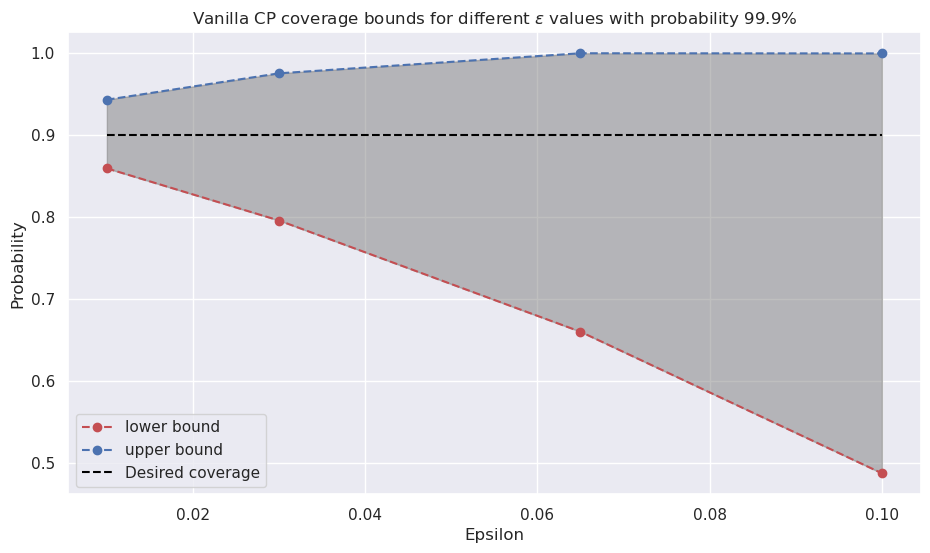

In [13]:
from utils.utils_notebooks import plot_vanilla_bounds_banner

plot_vanilla_bounds_banner(EPSILONS, ALPHA, DELTA, gamma_mins, gamma_maxs)

Importantly, these bounds hold uniformly accross noise levels.